In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, LSTM, Conv1D
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.options.mode.chained_assignment = None
tf.keras.utils.disable_interactive_logging()

sp500 = yf.Ticker('^GSPC')
sp500_data = sp500.history(period="20y", interval="1mo")
print(f'Downloaded {len(sp500_data)} months of data')

sp500_clean = sp500_data.drop(columns=['Dividends', 'Stock Splits'])

sp500_clean['MonthOfYear'] = [i.month for i in sp500_clean.index]

def create_sequences(data, seq_length=24, future_months=60):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length - future_months + 1):
        seq = data.iloc[i:i+seq_length]

        target_values = []
        for j in range(1, future_months + 1):
            target_values.append(data['Close'].iloc[i+seq_length+j-1])

        sequences.append(seq)
        targets.append(target_values)

    return sequences, targets

def standardize(sequences, targets):
    std_sequences = []
    std_targets = []

    for i, seq in enumerate(sequences):
        close_mean = seq['Close'].mean()
        close_std = seq['Close'].std()

        std_seq = seq.copy()

        for column in std_seq.columns:
            col_std = std_seq[column].std()
            col_mean = std_seq[column].mean()

            std_seq[column] = (std_seq[column] - col_mean) / col_std if col_std != 0 else 0

        std_target = [(t - close_mean) / close_std if close_std != 0 else 0 for t in targets[i]]

        if std_seq.isnull().values.any() or any(math.isnan(x) for x in std_target):
            continue

        std_sequences.append(std_seq)
        std_targets.append(std_target)

    return std_sequences, std_targets, (close_mean, close_std)

sequences, targets = create_sequences(sp500_clean, seq_length=24, future_months=60)
print(f'Created {len(sequences)} sequences')

std_sequences, std_targets, normalization_params = standardize(sequences, targets)
print(f'Standardized {len(std_sequences)} sequences')

split_idx = int(len(std_sequences) * 0.95)
train_sequences = std_sequences[:split_idx]
train_targets = std_targets[:split_idx]
test_sequences = std_sequences[split_idx:]
test_targets = std_targets[split_idx:]

print(f'Training sequences: {len(train_sequences)}')
print(f'Testing sequences: {len(test_sequences)}')

def prepare_model_input(sequences, targets):
    n_features = len(sequences[0].columns)
    X = np.array([seq.values for seq in sequences])
    y = np.array(targets)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    return X, y

X_train, y_train = prepare_model_input(train_sequences, train_targets)
X_test, y_test = prepare_model_input(test_sequences, test_targets)

with open('./sp500_norm_params.pkl', 'wb') as f:
    pickle.dump(normalization_params, f)

model = Sequential()

FILTERS = 64
SEQ_LENGTH = X_train.shape[1]
N_FEATURES = X_train.shape[2]
N_OUTPUT = y_train.shape[1]

model.add(Conv1D(filters=FILTERS, kernel_size=1, activation='swish', padding='same',
                 input_shape=(SEQ_LENGTH, N_FEATURES)))
model.add(BatchNormalization())
model.add(Reshape((SEQ_LENGTH, FILTERS)))
model.add(LSTM(units=128, activation='swish', return_sequences=True))
model.add(LSTM(units=64, activation='swish'))
model.add(Dense(units=N_OUTPUT, activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MAE

model.compile(
    loss=MeanAbsoluteError(),
    optimizer=optimizer,
    metrics=[MAE()]
)

checkpoint = ModelCheckpoint(
    './sp500_predictor.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING = 20

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('./training_history.png')
plt.close()

def predict_future(ticker_symbol='AAPL', model_path='./sp500_predictor.h5'):
    """
    Predict 5 years into the future for a given ticker
    """
    print(f'Downloading data for {ticker_symbol}...')
    ticker = yf.Ticker(ticker_symbol)
    ticker_data = ticker.history(period="2y", interval="1mo")  # Get 2 years of monthly data

    if len(ticker_data) < 24:
        print(f"Error: Not enough data for {ticker_symbol}. Need at least 24 months.")
        return None

    ticker_clean = ticker_data.iloc[-24:].drop(columns=['Dividends', 'Stock Splits'])
    ticker_clean['MonthOfYear'] = [i.month for i in ticker_clean.index]

    close_mean = ticker_clean['Close'].mean()
    close_std = ticker_clean['Close'].std()

    for column in ticker_clean.columns:
        col_std = ticker_clean[column].std()
        col_mean = ticker_clean[column].mean()
        ticker_clean[column] = (ticker_clean[column] - col_mean) / col_std if col_std != 0 else 0

    if ticker_clean.isnull().values.any():
        print(f"Error: Invalid data for {ticker_symbol}. Please try another ticker.")
        return None

    input_data = ticker_clean.values.reshape(1, 24, len(ticker_clean.columns))
    loaded_model = tf.keras.models.load_model(
        model_path,
        custom_objects={
            'MeanAbsoluteError': MeanAbsoluteError
        }
    )

    prediction = loaded_model.predict(input_data)[0]
    prediction = prediction * close_std + close_mean

    last_date = ticker_clean.index[-1]
    future_dates = []
    for i in range(1, len(prediction) + 1):
        future_month = last_date.month + i
        future_year = last_date.year + (future_month - 1) // 12
        future_month = ((future_month - 1) % 12) + 1
        future_date = datetime(future_year, future_month, 1)
        future_dates.append(future_date)

    pred_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Close': prediction
    })

    return pred_df

sample_prediction = predict_future('AAPL', './sp500_predictor.keras')
if sample_prediction is not None:
    print("\n=== 5-YEAR PREDICTION FOR AAPL ===")
    for i in range(0, 60, 12):
        if i < len(sample_prediction):
            date = sample_prediction['Date'].iloc[i]
            price = sample_prediction['Predicted_Close'].iloc[i]
            print(f"{date.strftime('%Y-%m')}: ${price:.2f}")

    sample_prediction.to_csv('./AAPL_prediction.csv', index=False)

print("Done! Model saved as 'sp500_predictor.h5'")

Downloaded 240 months of data
Creating sequences...
Created 157 sequences
Standardizing data...
Standardized 157 sequences
Training sequences: 149
Testing sequences: 8
Preparing model input...
Building model...
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(



=== 5-YEAR PREDICTION FOR AAPL ===
2025-05: $237.44
2026-05: $264.01
2027-05: $269.98
2028-05: $332.74
2029-05: $368.64
Done! Model saved as 'sp500_predictor.h5'


[*********************100%***********************]  1 of 1 completed

Fetching S&P 500 historical data...
Full data shape: (4593, 5), Monthly data shape: (219, 5)
Missing values in quarterly data: Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64



<ipython-input-93-bec2c3e49cbd>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500_full.asfreq('1M', method='ffill')
<ipython-input-93-bec2c3e49cbd>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500_monthly = sp500_monthly.fillna(method='ffill')


Training data shape: X=(146, 36, 1), y=(146,)
Testing data shape: X=(37, 36, 1), y=(37,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

# Train the model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Training the model...
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0090
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0127
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038 - val_loss: 0.0074
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0219
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 0.0071
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0098
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - val_loss: 0.0192
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0064
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - val_loss: 0.0143
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 12/100
10/10 ━━━━━━━━━━━

Evaluating the model...
Training loss: 0.0017
Testing loss: 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Mean Absolute Error: $312.95
Root Mean Square Error: $382.56
Average S&P 500 price in test set: $4730.91
Percentage error: 6.61%


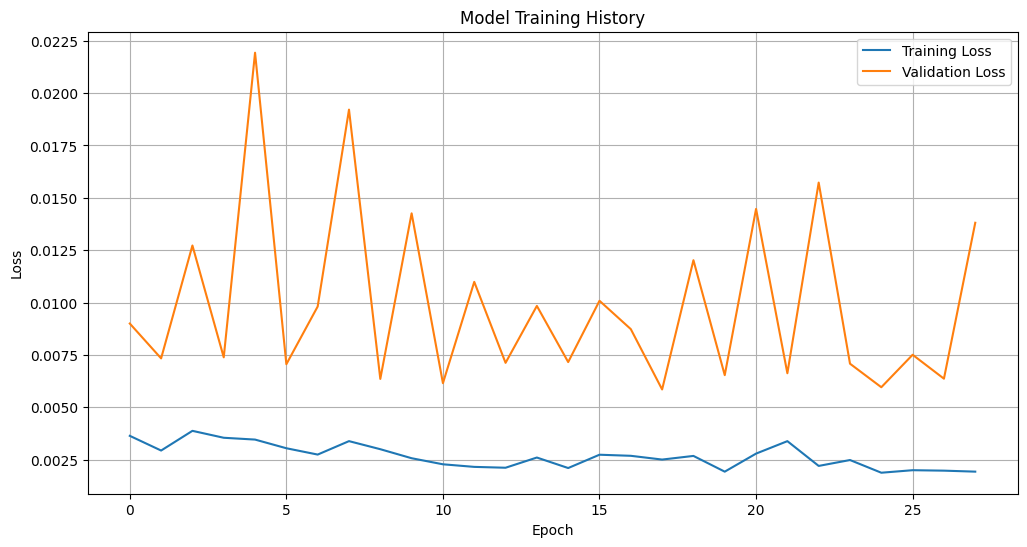

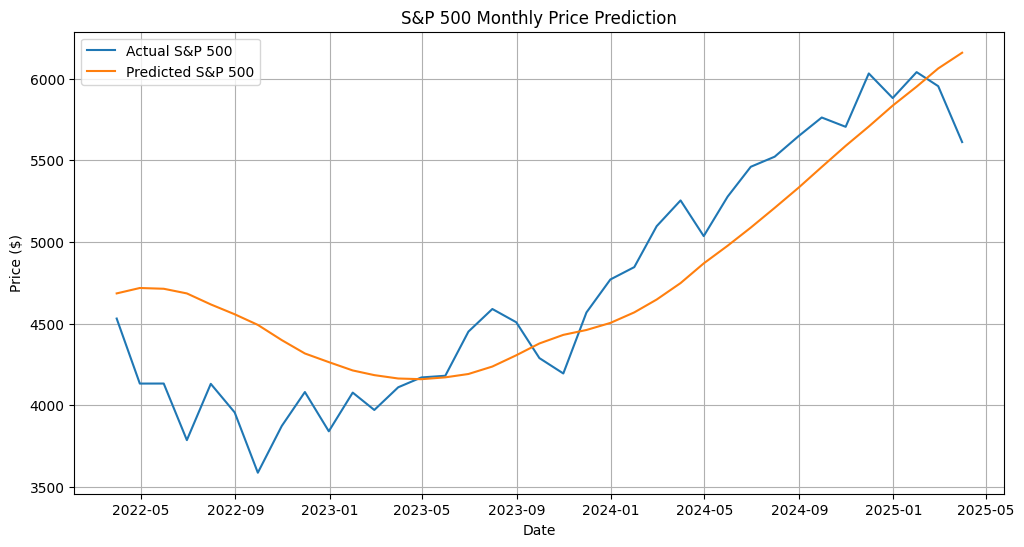

Predicting next 12 months (4 quarters)...

Predictions for next 24 months (quarterly):
         Date  Predicted_Close
0  2025-04-30      6213.721191
1  2025-05-31      6282.626953
2  2025-06-30      6364.565918
3  2025-07-31      6453.515137
4  2025-08-31      6547.869629
5  2025-09-30      6646.710449
6  2025-10-31      6749.518555
7  2025-11-30      6856.014648
8  2025-12-31      6966.030762
9  2026-01-31      7079.475586
10 2026-02-28      7196.327148
11 2026-03-31      7316.563965


<ipython-input-104-45e3777eee5a>:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='1M')


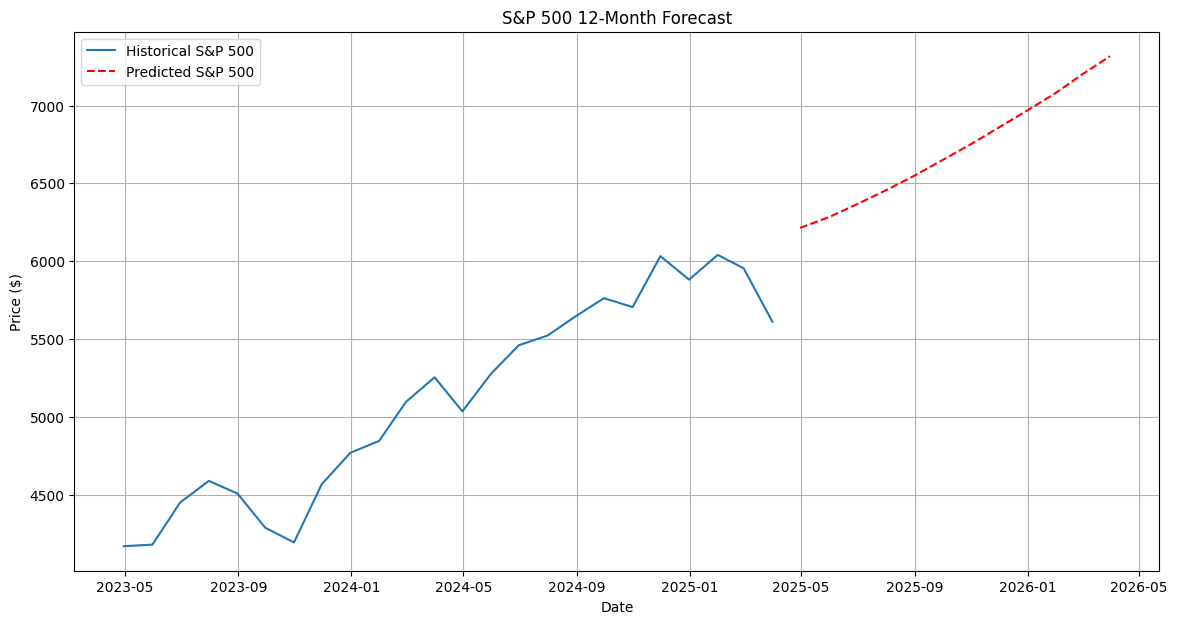

In [ ]:
# Evaluate the model
print("Evaluating the model...")
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Training loss: {train_loss:.4f}")
print(f"Testing loss: {test_loss:.4f}")

# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Square Error: ${rmse:.2f}")
print(f"Average S&P 500 price in test set: ${np.mean(y_test_inv):.2f}")
print(f"Percentage error: {(mae / np.mean(y_test_inv)) * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot test predictions
plt.figure(figsize=(12, 6))
test_dates = sp500_monthly.index[train_size+seq_length:]
plt.plot(test_dates, y_test_inv, label='Actual S&P 500')
plt.plot(test_dates, y_pred_inv, label='Predicted S&P 500')
plt.title('S&P 500 Monthly Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Predict next 24 months (2 years)
def predict_future_quarters(model, last_sequence, scaler, steps=24):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Reshape to match input shape expected by model
        current_sequence_reshaped = current_sequence.reshape(1, seq_length, 1)

        # Get prediction
        next_pred = model.predict(current_sequence_reshaped, verbose=0)

        # Add prediction to list
        future_predictions.append(next_pred[0, 0])

        # Update sequence
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])

    # Convert back to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

# Get the last sequence from our data
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape(-1)

# Generate predictions for next 8 quarters (24 months)
print("Predicting next 12 months (4 quarters)...")
future_quarters_scaled = predict_future_quarters(model, last_sequence, scaler, steps=12)

# Create future dates (quarterly)
last_date = sp500_monthly.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='1M')

# Create DataFrame with predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_quarters_scaled.flatten()
})

print("\nPredictions for next 24 months (quarterly):")
print(future_predictions_df)

# Plot historical data and predictions
plt.figure(figsize=(14, 7))
plt.plot(sp500_monthly.index[-24:], sp500_monthly['Close'].values[-24:], label='Historical S&P 500')
plt.plot(future_dates, future_quarters_scaled, 'r--', label='Predicted S&P 500')
plt.title('S&P 500 12-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()



[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



<ipython-input-73-90dedbbfa4c4>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aapl_monthly = aapl_data.asfreq('3M', method='ffill')
<ipython-input-73-90dedbbfa4c4>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_monthly = aapl_monthly.fillna(method='ffill')


Apple MAE: $19.91
Apple RMSE: $24.18
Average Apple price in test set: $180.66
Apple percentage error: 11.02%


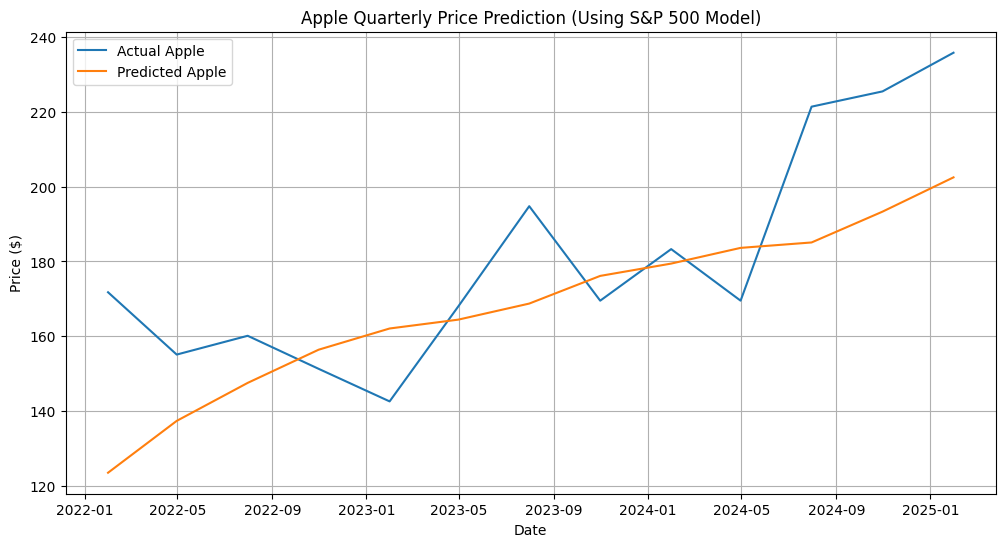


Apple predictions for next 24 months (quarterly):
         Date  Predicted_Close
0  2025-04-30       212.970184
1  2025-05-31       219.653168
2  2025-06-30       225.977890
3  2025-07-31       232.091400
4  2025-08-31       238.093033
5  2025-09-30       244.066864
6  2025-10-31       250.088135
7  2025-11-30       256.220734
8  2025-12-31       262.524261
9  2026-01-31       269.050323
10 2026-02-28       275.844055
11 2026-03-31       282.950104
12 2026-04-30       290.418915
13 2026-05-31       298.279724
14 2026-06-30       306.576263
15 2026-07-31       315.345551
16 2026-08-31       324.625214
17 2026-09-30       334.469910
18 2026-10-31       344.895782
19 2026-11-30       355.972809
20 2026-12-31       367.729187
21 2027-01-31       380.233826
22 2027-02-28       393.519806
23 2027-03-31       407.646515


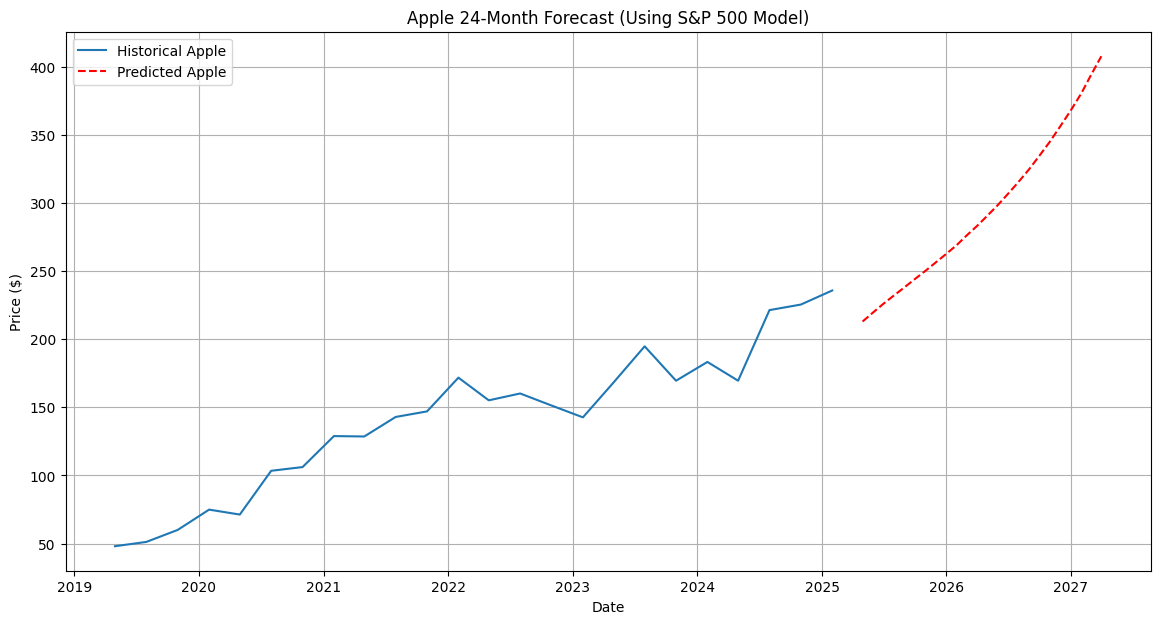

In [ ]:
aapl_data = yf.download('AAPL', start='2000-01-01', end='2025-04-04')
aapl_monthly = aapl_data.asfreq('3M', method='ffill')
aapl_monthly = aapl_monthly.fillna(method='ffill')

# Scale Apple data using a new scaler
aapl_scaler = MinMaxScaler(feature_range=(0, 1))
aapl_scaled = aapl_scaler.fit_transform(aapl_monthly['Close'].values.reshape(-1, 1))

# Create sequences
aapl_X = []
aapl_y = []
for i in range(seq_length, len(aapl_scaled)):
    aapl_X.append(aapl_scaled[i-seq_length:i, 0])
    aapl_y.append(aapl_scaled[i, 0])

aapl_X, aapl_y = np.array(aapl_X), np.array(aapl_y)
aapl_X = np.reshape(aapl_X, (aapl_X.shape[0], aapl_X.shape[1], 1))

# Split Apple data
aapl_train_size = int(len(aapl_X) * 0.8)
aapl_X_test = aapl_X[aapl_train_size:]
aapl_y_test = aapl_y[aapl_train_size:]

# Predict Apple prices using our S&P 500 trained model
aapl_y_pred = model.predict(aapl_X_test)

# Inverse transform
aapl_y_test_inv = aapl_scaler.inverse_transform(aapl_y_test.reshape(-1, 1))
aapl_y_pred_inv = aapl_scaler.inverse_transform(aapl_y_pred)

# Calculate Apple metrics
aapl_mae = mean_absolute_error(aapl_y_test_inv, aapl_y_pred_inv)
aapl_rmse = np.sqrt(mean_squared_error(aapl_y_test_inv, aapl_y_pred_inv))
print(f"Apple MAE: ${aapl_mae:.2f}")
print(f"Apple RMSE: ${aapl_rmse:.2f}")
print(f"Average Apple price in test set: ${np.mean(aapl_y_test_inv):.2f}")
print(f"Apple percentage error: {(aapl_mae / np.mean(aapl_y_test_inv)) * 100:.2f}%")

# Plot Apple predictions
plt.figure(figsize=(12, 6))
aapl_test_dates = aapl_monthly.index[aapl_train_size+seq_length:]
plt.plot(aapl_test_dates, aapl_y_test_inv, label='Actual Apple')
plt.plot(aapl_test_dates, aapl_y_pred_inv, label='Predicted Apple')
plt.title('Apple Quarterly Price Prediction (Using S&P 500 Model)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Predict next 12 months for Apple
aapl_last_sequence = aapl_scaled[-seq_length:].reshape(-1)
aapl_future_quarters_scaled = predict_future_quarters(model, aapl_last_sequence, aapl_scaler, steps=24)

# Create DataFrame with Apple predictions
aapl_future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': aapl_future_quarters_scaled.flatten()
})

print("\nApple predictions for next 24 months (quarterly):")
print(aapl_future_predictions_df)

# Plot historical Apple data and predictions
plt.figure(figsize=(14, 7))
plt.plot(aapl_monthly.index[-24:], aapl_monthly['Close'].values[-24:], label='Historical Apple')
plt.plot(future_dates, aapl_future_quarters_scaled, 'r--', label='Predicted Apple')
plt.title('Apple 24-Month Forecast (Using S&P 500 Model)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



<ipython-input-49-85d91649ee2f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aapl_quarterly = aapl_data.asfreq('3M', method='ffill')
<ipython-input-49-85d91649ee2f>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_quarterly = aapl_quarterly.fillna(method='ffill')


Apple MAE: $21.25
Apple RMSE: $28.80
Average Apple price in test set: $111.34
Apple percentage error: 19.08%


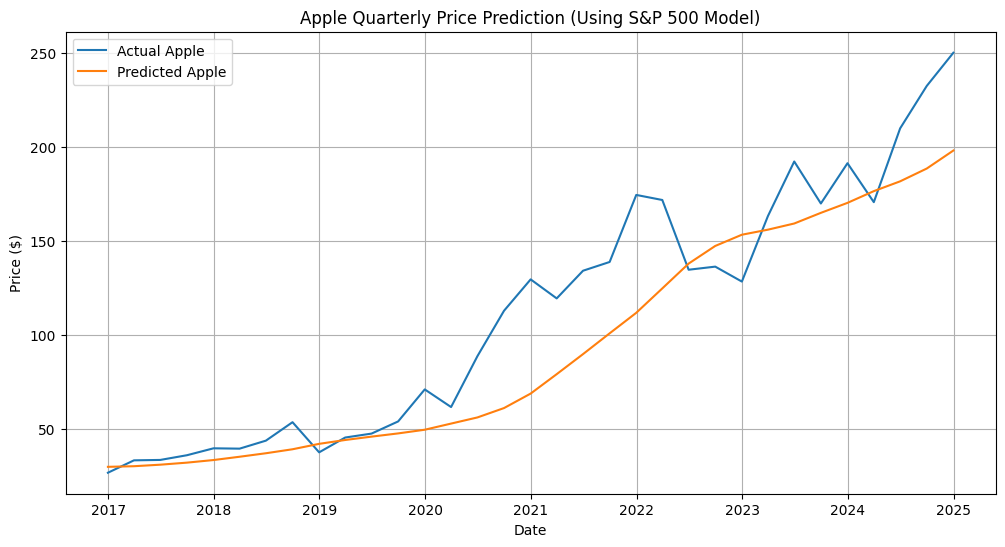


Apple predictions for next 24 months (quarterly):
        Date  Predicted_Close
0 2024-01-31       210.064331
1 2024-04-30       219.975159
2 2024-07-31       228.344498
3 2024-10-31       235.535507
4 2025-01-31       242.090240
5 2025-04-30       247.942245
6 2025-07-31       253.530975
7 2025-10-31       259.435760


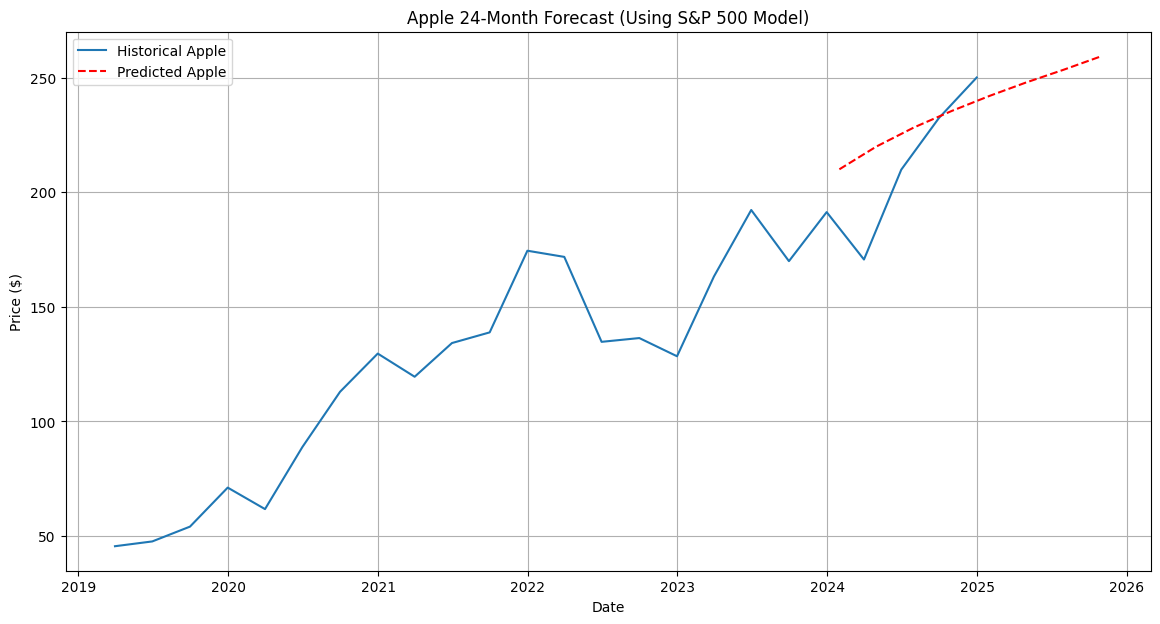

In [ ]:
aapl_data = yf.download('AAPL', start='1970-01-01', end='2025-03-03')
aapl_quarterly = aapl_data.asfreq('3M', method='ffill')
aapl_quarterly = aapl_quarterly.fillna(method='ffill')

# Scale Apple data using a new scaler
aapl_scaler = MinMaxScaler(feature_range=(0, 1))
aapl_scaled = aapl_scaler.fit_transform(aapl_quarterly['Close'].values.reshape(-1, 1))

# Create sequences
aapl_X = []
aapl_y = []
for i in range(seq_length, len(aapl_scaled)):
    aapl_X.append(aapl_scaled[i-seq_length:i, 0])
    aapl_y.append(aapl_scaled[i, 0])

aapl_X, aapl_y = np.array(aapl_X), np.array(aapl_y)
aapl_X = np.reshape(aapl_X, (aapl_X.shape[0], aapl_X.shape[1], 1))

# Split Apple data
aapl_train_size = int(len(aapl_X) * 0.8)
aapl_X_test = aapl_X[aapl_train_size:]
aapl_y_test = aapl_y[aapl_train_size:]

# Predict Apple prices using our S&P 500 trained model
aapl_y_pred = model.predict(aapl_X_test)

# Inverse transform
aapl_y_test_inv = aapl_scaler.inverse_transform(aapl_y_test.reshape(-1, 1))
aapl_y_pred_inv = aapl_scaler.inverse_transform(aapl_y_pred)

# Calculate Apple metrics
aapl_mae = mean_absolute_error(aapl_y_test_inv, aapl_y_pred_inv)
aapl_rmse = np.sqrt(mean_squared_error(aapl_y_test_inv, aapl_y_pred_inv))
print(f"Apple MAE: ${aapl_mae:.2f}")
print(f"Apple RMSE: ${aapl_rmse:.2f}")
print(f"Average Apple price in test set: ${np.mean(aapl_y_test_inv):.2f}")
print(f"Apple percentage error: {(aapl_mae / np.mean(aapl_y_test_inv)) * 100:.2f}%")

# Plot Apple predictions
plt.figure(figsize=(12, 6))
aapl_test_dates = aapl_quarterly.index[aapl_train_size+seq_length:]
plt.plot(aapl_test_dates, aapl_y_test_inv, label='Actual Apple')
plt.plot(aapl_test_dates, aapl_y_pred_inv, label='Predicted Apple')
plt.title('Apple Quarterly Price Prediction (Using S&P 500 Model)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Predict next 24 months for Apple
aapl_last_sequence = aapl_scaled[-seq_length:].reshape(-1)
aapl_future_quarters_scaled = predict_future_quarters(model, aapl_last_sequence, aapl_scaler, steps=24)

# Create DataFrame with Apple predictions
aapl_future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': aapl_future_quarters_scaled.flatten()
})

print("\nApple predictions for next 24 months (quarterly):")
print(aapl_future_predictions_df)

# Plot historical Apple data and predictions
plt.figure(figsize=(14, 7))
plt.plot(aapl_quarterly.index[-24:], aapl_quarterly['Close'].values[-24:], label='Historical Apple')
plt.plot(future_dates, aapl_future_quarters_scaled, 'r--', label='Predicted Apple')
plt.title('Apple 24-Month Forecast (Using S&P 500 Model)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import yfinance as yf

# Hyperparameters
seq_length = 24  # Use 24 months (2 years) to predict the next month
batch_size = 32
epochs = 100
learning_rate = 0.001


def load_data():
  #print("Fetching S&P 500 historical data...")
  sp500_full = yf.download('^GSPC', start='1980-01-01', end='2025-04-04')

  sp500_monthly = sp500_full.asfreq('1M', method='ffill')

  #print(f"Full data shape: {sp500_full.shape}, Monthly data shape: {sp500_monthly.shape}")
  close_prices = sp500_monthly['Close'].values.reshape(-1, 1)

  return close_prices


# Advanced data preprocessing function
def preprocess_data(data, seq_length):
    scaler_price = StandardScaler()
    scaled_data = scaler_price.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(scaled_data[i+seq_length])

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Add seasonality features (assuming monthly data)
    months = np.array([[(i % 12) + 1 for _ in range(1)] for i in range(len(X))])
    months_norm = months / 12.0  # Normalize to [0,1]

    # Add time features (capture long-term trends)
    time_idx = np.array([[[j/seq_length] for j in range(seq_length)] for _ in range(len(X))])

    return X, y, months_norm, time_idx, scaler_price

# Multi-input model with attention mechanism
def build_advanced_model(seq_length):
    price_input = Input(shape=(seq_length, 1), name='price_input')

    conv1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(price_input)
    conv2 = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(price_input)
    conv3 = Conv1D(filters=64, kernel_size=7, padding='same', activation='relu')(price_input)

    pool1 = MaxPooling1D(pool_size=2)(conv1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    cnn_features = Concatenate()([pool1, pool2, pool3])

    lstm1 = Bidirectional(LSTM(100, return_sequences=True,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)))(price_input)
    bn1 = BatchNormalization()(lstm1)
    drop1 = Dropout(0.3)(bn1)

    lstm2 = Bidirectional(LSTM(50, return_sequences=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)))(drop1)
    bn2 = BatchNormalization()(lstm2)
    drop2 = Dropout(0.3)(bn2)

    flat_cnn = Flatten()(cnn_features)

    concat = Concatenate()([drop2, flat_cnn])

    seasonality_input = Input(shape=(1,), name='seasonality_input')
    season_dense = Dense(12, activation='relu')(seasonality_input)

    all_features = Concatenate()([concat, season_dense])

    dense1 = Dense(100, activation='relu')(all_features)
    drop3 = Dropout(0.2)(dense1)
    dense2 = Dense(50, activation='relu')(drop3)
    output = Dense(1)(dense2)

    model = Model(inputs=[price_input, seasonality_input], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

# Training setup with cross-validation and callbacks
def train_model_with_validation(X, y, months, model):
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    best_val_loss = float('inf')
    best_model = None

    # Callbacks for training optimization
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001),
        ModelCheckpoint('best_price_model.h5', save_best_only=True, monitor='val_loss')
    ]

    # Train with cross-validation
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        months_train, months_val = months[train_idx], months[val_idx]

        # Train the model
        history = model.fit(
            [X_train, months_train], y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_val, months_val], y_val),
            callbacks=callbacks,
            verbose=1
        )

        # Keep track of best model
        val_loss = min(history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

    return best_model

# Function to make predictions
def predict_future_months(model, last_sequence, scaler, months_future, num_predictions=12):
    """
    Predict prices for future months using the trained model
    """
    predictions = []
    current_sequence = last_sequence.copy()

    for i in range(num_predictions):
        # Current month for seasonality (assuming we're predicting after the last known month)
        current_month = np.array([[(months_future + i) % 12 + 1]]) / 12.0

        # Make prediction for next month
        pred = model.predict([current_sequence.reshape(1, seq_length, 1), current_month])
        predictions.append(pred[0][0])

        # Update sequence for next prediction (rolling window)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred

    # Inverse transform predictions back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# Ensemble model for even better predictions
def build_ensemble_model(X, y, months):
    models = []

    # Base LSTM model
    model1 = build_advanced_model(seq_length)
    models.append(model1)

    # Variant with different hyperparameters
    model2 = build_advanced_model(seq_length)
    models.append(model2)

    # Train models
    trained_models = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        trained_model = train_model_with_validation(X, y, months, model)
        trained_models.append(trained_model)

    return trained_models

data = load_data()
X, y, months, time_idx, scaler = preprocess_data(data, seq_length)
ensemble_models = build_ensemble_model(X, y, months)

last_known_sequence = X[-1]
last_known_month = (len(data) % 12) + 1
predictions = []

for model in ensemble_models:
    model_preds = predict_future_months(model, last_known_sequence, scaler, last_known_month)
    predictions.append(model_preds)

ensemble_predictions = np.mean(np.array(predictions), axis=0)

print("Model performance metrics:")
for i, model in enumerate(ensemble_models):
    print(f"Model {i+1} metrics:", model.evaluate([X[-100:], months[-100:]], y[-100:]))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-08e2782f6162>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500_full.asfreq('1M', method='ffill')


Training model 1
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.1647 - mae: 0.7718

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - loss: 1.1028 - mae: 0.7272 - val_loss: 0.6032 - val_mae: 0.4513 - learning_rate: 0.0010
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 0.7057 - mae: 0.5056

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.6001 - mae: 0.3725 - val_loss: 0.4811 - val_mae: 0.2924 - learning_rate: 0.0010
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4842 - mae: 0.2540

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.4811 - mae: 0.2563 - val_loss: 0.4422 - val_mae: 0.2291 - learning_rate: 0.0010
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4461 - mae: 0.1993

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.4364 - mae: 0.1807 - val_loss: 0.3838 - val_mae: 0.0319 - learning_rate: 0.0010
Epoch 5/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4188 - mae: 0.1465

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.4285 - mae: 0.1637 - val_loss: 0.3778 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 6/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4128 - mae: 0.1574

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.4095 - mae: 0.1512 - val_loss: 0.3763 - val_mae: 0.0770 - learning_rate: 0.0010
Epoch 7/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4006 - mae: 0.1421

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3977 - mae: 0.1393 - val_loss: 0.3757 - val_mae: 0.1086 - learning_rate: 0.0010
Epoch 8/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3968 - mae: 0.1401

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3968 - mae: 0.1460 - val_loss: 0.3601 - val_mae: 0.0580 - learning_rate: 0.0010
Epoch 9/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3928 - mae: 0.1601

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3859 - mae: 0.1446 - val_loss: 0.3521 - val_mae: 0.0476 - learning_rate: 0.0010
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3774 - mae: 0.1427 - val_loss: 0.3548 - val_mae: 0.1047 - learning_rate: 0.0010
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3652 - mae: 0.1177 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.3647 - mae: 0.1168 - val_loss: 0.3510 - val_mae: 0.1179 - learning_rate: 0.0010
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3576 - mae: 0.1209 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - loss: 0.3571 - mae: 0.1203 - val_loss: 0.3349 - val_mae: 0.0683 - learning_rate: 0.0010
Epoch 13/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3565 - mae: 0.1390

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3523 - mae: 0.1301 - val_loss: 0.3242 - val_mae: 0.0345 - learning_rate: 0.0010
Epoch 14/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3459 - mae: 0.1249

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3434 - mae: 0.1226 - val_loss: 0.3193 - val_mae: 0.0510 - learning_rate: 0.0010
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3333 - mae: 0.1066 - val_loss: 0.3211 - val_mae: 0.1015 - learning_rate: 0.0010
Epoch 16/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3331 - mae: 0.1194

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3315 - mae: 0.1214 - val_loss: 0.3150 - val_mae: 0.1027 - learning_rate: 0.0010
Epoch 17/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3307 - mae: 0.1323

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3221 - mae: 0.1109 - val_loss: 0.3018 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 18/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3138 - mae: 0.1094

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.3136 - mae: 0.1093 - val_loss: 0.2944 - val_mae: 0.0538 - learning_rate: 0.0010
Epoch 19/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.3077 - mae: 0.0995

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.3058 - mae: 0.1011 - val_loss: 0.2912 - val_mae: 0.0731 - learning_rate: 0.0010
Epoch 20/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2999 - mae: 0.0933 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.3000 - mae: 0.0942 - val_loss: 0.2878 - val_mae: 0.0883 - learning_rate: 0.0010
Epoch 21/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2942 - mae: 0.0997

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2926 - mae: 0.0973 - val_loss: 0.2810 - val_mae: 0.0827 - learning_rate: 0.0010
Epoch 22/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2917 - mae: 0.1070

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2902 - mae: 0.1042 - val_loss: 0.2719 - val_mae: 0.0621 - learning_rate: 0.0010
Epoch 23/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2777 - mae: 0.0748

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2779 - mae: 0.0832 - val_loss: 0.2638 - val_mae: 0.0410 - learning_rate: 0.0010
Epoch 24/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2817 - mae: 0.1225 - val_loss: 0.2646 - val_mae: 0.0852 - learning_rate: 0.0010
Epoch 25/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2786 - mae: 0.1197

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2755 - mae: 0.1101 - val_loss: 0.2597 - val_mae: 0.0881 - learning_rate: 0.0010
Epoch 26/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2595 - mae: 0.0799

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2598 - mae: 0.0852 - val_loss: 0.2501 - val_mae: 0.0613 - learning_rate: 0.0010
Epoch 27/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2580 - mae: 0.0884

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2571 - mae: 0.0899 - val_loss: 0.2472 - val_mae: 0.0755 - learning_rate: 0.0010
Epoch 28/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2514 - mae: 0.0835

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2523 - mae: 0.0884 - val_loss: 0.2471 - val_mae: 0.1027 - learning_rate: 0.0010
Epoch 29/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2513 - mae: 0.1004

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2511 - mae: 0.1000 - val_loss: 0.2358 - val_mae: 0.0672 - learning_rate: 0.0010
Epoch 30/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2483 - mae: 0.1001

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2454 - mae: 0.0973 - val_loss: 0.2303 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 31/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2362 - mae: 0.0869

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2356 - mae: 0.0879 - val_loss: 0.2292 - val_mae: 0.0848 - learning_rate: 0.0010
Epoch 32/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2364 - mae: 0.1011

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2342 - mae: 0.0971 - val_loss: 0.2288 - val_mae: 0.1064 - learning_rate: 0.0010
Epoch 33/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2296 - mae: 0.0877

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2279 - mae: 0.0876 - val_loss: 0.2189 - val_mae: 0.0774 - learning_rate: 0.0010
Epoch 34/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2231 - mae: 0.0833

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2232 - mae: 0.0865 - val_loss: 0.2112 - val_mae: 0.0565 - learning_rate: 0.0010
Epoch 35/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2167 - mae: 0.0803 - val_loss: 0.2119 - val_mae: 0.0872 - learning_rate: 0.0010
Epoch 36/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2151 - mae: 0.0875

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2171 - mae: 0.0966 - val_loss: 0.2088 - val_mae: 0.0933 - learning_rate: 0.0010
Epoch 37/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2120 - mae: 0.0887

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2104 - mae: 0.0858 - val_loss: 0.1980 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 38/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2059 - mae: 0.0849

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2047 - mae: 0.0833 - val_loss: 0.1978 - val_mae: 0.0773 - learning_rate: 0.0010
Epoch 39/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1976 - mae: 0.0699 - val_loss: 0.2025 - val_mae: 0.1200 - learning_rate: 0.0010
Epoch 40/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1958 - mae: 0.0741

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1955 - mae: 0.0758 - val_loss: 0.1942 - val_mae: 0.0997 - learning_rate: 0.0010
Epoch 41/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1962 - mae: 0.0978

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1950 - mae: 0.0922 - val_loss: 0.1848 - val_mae: 0.0683 - learning_rate: 0.0010
Epoch 42/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1875 - mae: 0.0704

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.1881 - mae: 0.0756 - val_loss: 0.1823 - val_mae: 0.0750 - learning_rate: 0.0010
Epoch 43/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1826 - mae: 0.0694 - val_loss: 0.1842 - val_mae: 0.1042 - learning_rate: 0.0010
Epoch 44/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.1824 - mae: 0.0824

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.1830 - mae: 0.0859 - val_loss: 0.1773 - val_mae: 0.0867 - learning_rate: 0.0010
Epoch 45/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1757 - mae: 0.0664

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1773 - mae: 0.0748 - val_loss: 0.1693 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 46/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1734 - mae: 0.0672

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1727 - mae: 0.0680 - val_loss: 0.1658 - val_mae: 0.0572 - learning_rate: 0.0010
Epoch 47/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1727 - mae: 0.0874

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1710 - mae: 0.0799 - val_loss: 0.1646 - val_mae: 0.0712 - learning_rate: 0.0010
Epoch 48/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1679 - mae: 0.0745

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1675 - mae: 0.0761 - val_loss: 0.1645 - val_mae: 0.0887 - learning_rate: 0.0010
Epoch 49/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1625 - mae: 0.0669

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1630 - mae: 0.0726 - val_loss: 0.1563 - val_mae: 0.0579 - learning_rate: 0.0010
Epoch 50/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1597 - mae: 0.0688

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1602 - mae: 0.0747 - val_loss: 0.1513 - val_mae: 0.0408 - learning_rate: 0.0010
Epoch 51/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1586 - mae: 0.0790 - val_loss: 0.1519 - val_mae: 0.0687 - learning_rate: 0.0010
Epoch 52/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1592 - mae: 0.0901

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1568 - mae: 0.0821 - val_loss: 0.1478 - val_mae: 0.0607 - learning_rate: 0.0010
Epoch 53/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1470 - mae: 0.0520

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1484 - mae: 0.0585 - val_loss: 0.1442 - val_mae: 0.0549 - learning_rate: 0.0010
Epoch 54/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1459 - mae: 0.0553

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1451 - mae: 0.0541 - val_loss: 0.1434 - val_mae: 0.0690 - learning_rate: 0.0010
Epoch 55/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1451 - mae: 0.0688

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1460 - mae: 0.0698 - val_loss: 0.1420 - val_mae: 0.0766 - learning_rate: 0.0010
Epoch 56/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1406 - mae: 0.0538

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1409 - mae: 0.0600 - val_loss: 0.1357 - val_mae: 0.0521 - learning_rate: 0.0010
Epoch 57/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1439 - mae: 0.0854

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1415 - mae: 0.0746 - val_loss: 0.1353 - val_mae: 0.0681 - learning_rate: 0.0010
Epoch 58/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1385 - mae: 0.0765 - val_loss: 0.1354 - val_mae: 0.0830 - learning_rate: 0.0010
Epoch 59/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1354 - mae: 0.0636

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1342 - mae: 0.0639 - val_loss: 0.1286 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 60/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.1292 - mae: 0.0545

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.1312 - mae: 0.0628 - val_loss: 0.1253 - val_mae: 0.0489 - learning_rate: 0.0010
Epoch 61/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1313 - mae: 0.0758 - val_loss: 0.1287 - val_mae: 0.0859 - learning_rate: 0.0010
Epoch 62/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1301 - mae: 0.0846

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1285 - mae: 0.0789 - val_loss: 0.1232 - val_mae: 0.0676 - learning_rate: 0.0010
Epoch 63/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1242 - mae: 0.0639

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1245 - mae: 0.0684 - val_loss: 0.1208 - val_mae: 0.0670 - learning_rate: 0.0010
Epoch 64/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1238 - mae: 0.0704 - val_loss: 0.1212 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 65/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1230 - mae: 0.0811

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1207 - mae: 0.0703 - val_loss: 0.1176 - val_mae: 0.0740 - learning_rate: 0.0010
Epoch 66/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1181 - mae: 0.0723

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1170 - mae: 0.0656 - val_loss: 0.1146 - val_mae: 0.0687 - learning_rate: 0.0010
Epoch 67/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1172 - mae: 0.0704 - val_loss: 0.1188 - val_mae: 0.1021 - learning_rate: 0.0010
Epoch 68/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1123 - mae: 0.0578 - val_loss: 0.1178 - val_mae: 0.1067 - learning_rate: 0.0010
Epoch 69/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1134 - mae: 0.0723

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1128 - mae: 0.0683 - val_loss: 0.1104 - val_mae: 0.0791 - learning_rate: 0.0010
Epoch 70/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1093 - mae: 0.0657

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1100 - mae: 0.0677 - val_loss: 0.1091 - val_mae: 0.0824 - learning_rate: 0.0010
Epoch 71/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1074 - mae: 0.0634

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1078 - mae: 0.0649 - val_loss: 0.1081 - val_mae: 0.0873 - learning_rate: 0.0010
Epoch 72/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1039 - mae: 0.0502

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1033 - mae: 0.0519 - val_loss: 0.1053 - val_mae: 0.0820 - learning_rate: 0.0010
Epoch 73/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1048 - mae: 0.0716

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1028 - mae: 0.0610 - val_loss: 0.1021 - val_mae: 0.0747 - learning_rate: 0.0010
Epoch 74/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1016 - mae: 0.0606 - val_loss: 0.1044 - val_mae: 0.0963 - learning_rate: 0.0010
Epoch 75/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0985 - mae: 0.0552 - val_loss: 0.1024 - val_mae: 0.0945 - learning_rate: 0.0010
Epoch 76/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0978 - mae: 0.0544

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0968 - mae: 0.0533 - val_loss: 0.0984 - val_mae: 0.0827 - learning_rate: 0.0010
Epoch 77/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0980 - mae: 0.0736

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0962 - mae: 0.0635 - val_loss: 0.0952 - val_mae: 0.0741 - learning_rate: 0.0010
Epoch 78/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0943 - mae: 0.0591 - val_loss: 0.0982 - val_mae: 0.0992 - learning_rate: 0.0010
Epoch 79/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1000 - mae: 0.0820

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0967 - mae: 0.0734 - val_loss: 0.0919 - val_mae: 0.0741 - learning_rate: 0.0010
Epoch 80/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0905 - mae: 0.0543

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0910 - mae: 0.0591 - val_loss: 0.0877 - val_mae: 0.0570 - learning_rate: 0.0010
Epoch 81/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0878 - mae: 0.0523 - val_loss: 0.0942 - val_mae: 0.1022 - learning_rate: 0.0010
Epoch 82/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0880 - mae: 0.0589 - val_loss: 0.0895 - val_mae: 0.0860 - learning_rate: 0.0010
Epoch 83/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0867 - mae: 0.0597

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0860 - mae: 0.0578 - val_loss: 0.0823 - val_mae: 0.0496 - learning_rate: 0.0010
Epoch 84/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0854 - mae: 0.0579

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0860 - mae: 0.0652 - val_loss: 0.0818 - val_mae: 0.0575 - learning_rate: 0.0010
Epoch 85/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0835 - mae: 0.0589 - val_loss: 0.0840 - val_mae: 0.0794 - learning_rate: 0.0010
Epoch 86/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0801 - mae: 0.0435

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0822 - mae: 0.0545 - val_loss: 0.0806 - val_mae: 0.0678 - learning_rate: 0.0010
Epoch 87/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0798 - mae: 0.0566

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0798 - mae: 0.0576 - val_loss: 0.0791 - val_mae: 0.0671 - learning_rate: 0.0010
Epoch 88/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0822 - mae: 0.0708

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0811 - mae: 0.0685 - val_loss: 0.0786 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 89/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0781 - mae: 0.0594

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0774 - mae: 0.0549 - val_loss: 0.0756 - val_mae: 0.0608 - learning_rate: 0.0010
Epoch 90/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0780 - mae: 0.0639

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0770 - mae: 0.0619 - val_loss: 0.0749 - val_mae: 0.0647 - learning_rate: 0.0010
Epoch 91/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0736 - mae: 0.0499 - val_loss: 0.0764 - val_mae: 0.0808 - learning_rate: 0.0010
Epoch 92/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0731 - mae: 0.0532 - val_loss: 0.0769 - val_mae: 0.0897 - learning_rate: 0.0010
Epoch 93/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0722 - mae: 0.0590

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0721 - mae: 0.0562 - val_loss: 0.0708 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 94/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0709 - mae: 0.0534 - val_loss: 0.0739 - val_mae: 0.0865 - learning_rate: 0.0010
Epoch 95/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0725 - mae: 0.0631

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0702 - mae: 0.0538 - val_loss: 0.0693 - val_mae: 0.0671 - learning_rate: 0.0010
Epoch 96/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0713 - mae: 0.0649

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0703 - mae: 0.0626 - val_loss: 0.0674 - val_mae: 0.0617 - learning_rate: 0.0010
Epoch 97/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0681 - mae: 0.0580 - val_loss: 0.0714 - val_mae: 0.0909 - learning_rate: 0.0010
Epoch 98/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0682 - mae: 0.0635 - val_loss: 0.0678 - val_mae: 0.0773 - learning_rate: 0.0010
Epoch 99/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0686 - mae: 0.0648

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0669 - mae: 0.0594 - val_loss: 0.0623 - val_mae: 0.0474 - learning_rate: 0.0010
Epoch 100/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0656 - mae: 0.0617 - val_loss: 0.0705 - val_mae: 0.1014 - learning_rate: 0.0010
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0668 - mae: 0.0699 - val_loss: 0.1100 - val_mae: 0.1851 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0613 - mae: 0.0514 - val_loss: 0.1041 - val_mae: 0.1789 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0594 - mae: 0.0488 - val_loss: 0.0981 - val_mae: 0.1700 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0590 - mae: 0.0571 - val_loss: 0.0964 - val_mae: 0.1694 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0562 - mae: 0.0539 - val_loss: 0.0983 - val_mae: 0.1758 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0293 - mae: 0.0424 - val_loss: 0.0581 - val_mae: 0.1391 - learning_rate: 5.0000e-04
Epoch 28/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0286 - mae: 0.0401

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0284 - mae: 0.0389 - val_loss: 0.0544 - val_mae: 0.1326 - learning_rate: 5.0000e-04
Epoch 29/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0290 - mae: 0.0448

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0290 - mae: 0.0445 - val_loss: 0.0503 - val_mae: 0.1239 - learning_rate: 5.0000e-04
Epoch 30/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0273 - mae: 0.0365

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0275 - mae: 0.0379 - val_loss: 0.0502 - val_mae: 0.1261 - learning_rate: 5.0000e-04
Epoch 31/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0270 - mae: 0.0386

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0271 - mae: 0.0387 - val_loss: 0.0474 - val_mae: 0.1214 - learning_rate: 5.0000e-04
Epoch 32/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0267 - mae: 0.0372 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0267 - mae: 0.0372 - val_loss: 0.0431 - val_mae: 0.1109 - learning_rate: 5.0000e-04
Epoch 33/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0264 - mae: 0.0379 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0263 - mae: 0.0372 - val_loss: 0.0405 - val_mae: 0.1065 - learning_rate: 5.0000e-04
Epoch 34/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0257 - mae: 0.0354

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0257 - mae: 0.0366 - val_loss: 0.0388 - val_mae: 0.1032 - learning_rate: 5.0000e-04
Epoch 35/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0250 - mae: 0.0319

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0250 - mae: 0.0323 - val_loss: 0.0379 - val_mae: 0.1012 - learning_rate: 5.0000e-04
Epoch 36/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0246 - mae: 0.0314

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0247 - mae: 0.0329 - val_loss: 0.0379 - val_mae: 0.1003 - learning_rate: 5.0000e-04
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0243 - mae: 0.0334

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0243 - mae: 0.0335 - val_loss: 0.0355 - val_mae: 0.0949 - learning_rate: 5.0000e-04
Epoch 38/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0244 - mae: 0.0364 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0244 - mae: 0.0368 - val_loss: 0.0351 - val_mae: 0.0959 - learning_rate: 5.0000e-04
Epoch 39/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0243 - mae: 0.0411

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0241 - mae: 0.0391 - val_loss: 0.0347 - val_mae: 0.0949 - learning_rate: 5.0000e-04
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0235 - mae: 0.0337 - val_loss: 0.0353 - val_mae: 0.0942 - learning_rate: 5.0000e-04
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0235 - mae: 0.0396 - val_loss: 0.0350 - val_mae: 0.0928 - learning_rate: 5.0000e-04
Epoch 42/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0229 - mae: 0.0348

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0228 - mae: 0.0348 - val_loss: 0.0337 - val_mae: 0.0931 - learning_rate: 5.0000e-04
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0230 - mae: 0.0403 - val_loss: 0.0358 - val_mae: 0.0954 - learning_rate: 5.0000e-04
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0227 - mae: 0.0398 - val_loss: 0.0403 - val_mae: 0.1076 - learning_rate: 5.0000e-04
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0222 - mae: 0.0411 - val_loss: 0.0520 - val_mae: 0.1337 - learning_rate: 5.0000e-04
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0215 - mae: 0.0349 - val_loss: 0.0513 - val_mae: 0.1345 - learning_rate: 5.0000e-04
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0208 - mae: 0.0328 - val_loss: 0.0466 - val_mae: 0.1247 - learning_rate: 5.0000e-04
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0205 - mae: 0.0330 - val_loss: 0.0495 - val_mae: 0.1320 - learning_rate: 2.5000e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0294 - mae: 0.0712 - val_loss: 0.0328 - val_mae: 0.0891 - learning_rate: 6.2500e-05
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - mae: 0.0644

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0281 - mae: 0.0637 - val_loss: 0.0275 - val_mae: 0.0634 - learning_rate: 6.2500e-05
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0274 - mae: 0.0633 - val_loss: 0.0287 - val_mae: 0.0734 - learning_rate: 6.2500e-05
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0294 - mae: 0.0648 - val_loss: 0.0322 - val_mae: 0.0858 - learning_rate: 6.2500e-05
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0250 - mae: 0.0519 - val_loss: 0.0336 - val_mae: 0.0939 - learning_rate: 6.2500e-05
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0256 - mae: 0.0547

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0256 - mae: 0.0545 - val_loss: 0.0273 - val_mae: 0.0706 - learning_rate: 6.2500e-05
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0257 - mae: 0.0539 - val_loss: 0.0305 - val_mae: 0.0854 - learning_rate: 6.2500e-05
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0267 - mae: 0.0615 - val_loss: 0.0311 - val_mae: 0.0892 - learning_rate: 6.2500e-05
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0249 - mae: 0.0496 - val_loss: 0.0277 - val_mae: 0.0737 - learning_rate: 6.2500e-05
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0260 - mae: 0.0572 - val_loss: 0.0286 - val_mae: 0.0753 - learning_rate: 6.2500e-05
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0254 - mae: 0.0529 - val_loss: 0.0274 - val_mae: 0.0715 - learning_rate: 6.2500e-05
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0246 - mae: 0.0525 - val_loss: 0.0279 - val_mae: 0.0719 - learning_rate: 3.1250e-05

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0244 - mae: 0.0500 - val_loss: 0.0265 - val_mae: 0.0655 - learning_rate: 3.1250e-05
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0260 - mae: 0.0581 - val_loss: 0.0266 - val_mae: 0.0638 - learning_rate: 3.1250e-05
Epoch 17/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0254 - mae: 0.0537

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0253 - mae: 0.0537 - val_loss: 0.0249 - val_mae: 0.0569 - learning_rate: 3.1250e-05
Epoch 18/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0239 - mae: 0.0507

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0241 - mae: 0.0509 - val_loss: 0.0247 - val_mae: 0.0562 - learning_rate: 3.1250e-05
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0243 - mae: 0.0481 - val_loss: 0.0249 - val_mae: 0.0559 - learning_rate: 3.1250e-05
Epoch 20/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0256 - mae: 0.0568

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0252 - mae: 0.0552 - val_loss: 0.0243 - val_mae: 0.0528 - learning_rate: 3.1250e-05
Epoch 21/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0239 - mae: 0.0518

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0239 - mae: 0.0514 - val_loss: 0.0241 - val_mae: 0.0497 - learning_rate: 3.1250e-05
Epoch 22/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0238 - mae: 0.0494 - val_loss: 0.0245 - val_mae: 0.0501 - learning_rate: 3.1250e-05
Epoch 23/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0241 - mae: 0.0486

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0242 - mae: 0.0489 - val_loss: 0.0239 - val_mae: 0.0469 - learning_rate: 3.1250e-05
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0236 - mae: 0.0477

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0236 - mae: 0.0479 - val_loss: 0.0235 - val_mae: 0.0477 - learning_rate: 3.1250e-05
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0234 - mae: 0.0465 - val_loss: 0.0247 - val_mae: 0.0609 - learning_rate: 3.1250e-05
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0243 - mae: 0.0482 - val_loss: 0.0243 - val_mae: 0.0558 - learning_rate: 3.1250e-05
Epoch 27/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0241 - mae: 0.0503 - val_loss: 0.0244 - val_mae: 0.0568 - learning_rate: 3.1250e-05
Epoch 28/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0259 - mae: 0.0527 - val_loss: 0.0243 - val_mae: 0.0559 - learning_rate: 3.1250e-05
Epoch 29/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0235 - mae: 0.0492 - val_loss: 0.0241 - val_mae: 0.0555 - learning_rate: 3.1250e-05
Epoch 30/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0235 - mae: 0.0500 - val_loss: 0.0240 - val_mae: 0.0546 - learning_rate: 1.5625e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0238 - mae: 0.0519 - val_loss: 0.0234 - val_mae: 0.0519 - learning_rate: 1.0000e-05
Epoch 39/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231 - mae: 0.0453

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0232 - mae: 0.0456 - val_loss: 0.0233 - val_mae: 0.0520 - learning_rate: 1.0000e-05
Epoch 40/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0238 - mae: 0.0504

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0237 - mae: 0.0505 - val_loss: 0.0233 - val_mae: 0.0516 - learning_rate: 1.0000e-05
Epoch 41/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231 - mae: 0.0486

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0231 - mae: 0.0483 - val_loss: 0.0233 - val_mae: 0.0512 - learning_rate: 1.0000e-05
Epoch 42/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0231 - mae: 0.0458

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0232 - mae: 0.0461 - val_loss: 0.0232 - val_mae: 0.0510 - learning_rate: 1.0000e-05
Epoch 43/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0233 - mae: 0.0496

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0234 - mae: 0.0500 - val_loss: 0.0231 - val_mae: 0.0506 - learning_rate: 1.0000e-05
Epoch 44/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0237 - mae: 0.0470 - val_loss: 0.0231 - val_mae: 0.0506 - learning_rate: 1.0000e-05
Epoch 45/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0232 - mae: 0.0498 - val_loss: 0.0231 - val_mae: 0.0503 - learning_rate: 1.0000e-05
Epoch 46/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0235 - mae: 0.0503 - val_loss: 0.0231 - val_mae: 0.0499 - learning_rate: 1.0000e-05
Epoch 47/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0242 - mae: 0.0508 - val_loss: 0.0231 - val_mae: 0.0497 - learning_rate: 1.0000e-05
Epoch 48/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - mae: 0.0507

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0239 - mae: 0.0503 - val_loss: 0.0230 - val_mae: 0.0489 - learning_rate: 1.0000e-05
Epoch 49/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0227 - mae: 0.0451

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0229 - mae: 0.0464 - val_loss: 0.0229 - val_mae: 0.0490 - learning_rate: 1.0000e-05
Epoch 50/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0229 - mae: 0.0463 - val_loss: 0.0229 - val_mae: 0.0496 - learning_rate: 1.0000e-05
Epoch 51/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0236 - mae: 0.0509 - val_loss: 0.0229 - val_mae: 0.0497 - learning_rate: 1.0000e-05
Epoch 52/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0228 - mae: 0.0460

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0228 - mae: 0.0460 - val_loss: 0.0228 - val_mae: 0.0490 - learning_rate: 1.0000e-05
Epoch 53/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0220 - mae: 0.0426

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0221 - mae: 0.0427 - val_loss: 0.0227 - val_mae: 0.0482 - learning_rate: 1.0000e-05
Epoch 54/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0223 - mae: 0.0409

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0224 - mae: 0.0417 - val_loss: 0.0226 - val_mae: 0.0476 - learning_rate: 1.0000e-05
Epoch 55/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0226 - mae: 0.0448 - val_loss: 0.0226 - val_mae: 0.0482 - learning_rate: 1.0000e-05
Epoch 56/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0231 - mae: 0.0499 - val_loss: 0.0226 - val_mae: 0.0488 - learning_rate: 1.0000e-05
Epoch 57/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0228 - mae: 0.0432 - val_loss: 0.0228 - val_mae: 0.0498 - learning_rate: 1.0000e-05
Epoch 58/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0226 - mae: 0.0448 - val_loss: 0.0230 - val_mae: 0.0508 - learning_rate: 1.0000e-05
Epoch 59/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0234 - mae: 0.0487 - val_loss: 0.0231 - val_mae: 0.0519 - learning_rate: 1.0000e-05
Epoch 60/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0230 - mae: 0.0453 - val_loss: 0.0231 - val_mae: 0.0522 - learning_rate: 1.0000e-0

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - loss: 0.8464 - mae: 0.5712 - val_loss: 0.4399 - val_mae: 0.2012 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5261 - mae: 0.2806 - val_loss: 0.5591 - val_mae: 0.4047 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4863 - mae: 0.2770 - val_loss: 0.4695 - val_mae: 0.2860 - learning_rate: 0.0010
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4577 - mae: 0.2294

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.4425 - mae: 0.1968 - val_loss: 0.3801 - val_mae: 0.0357 - learning_rate: 0.0010
Epoch 5/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4177 - mae: 0.1669

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.4242 - mae: 0.1787 - val_loss: 0.3723 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.4025 - mae: 0.1469 - val_loss: 0.3757 - val_mae: 0.1057 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3923 - mae: 0.1370 - val_loss: 0.3898 - val_mae: 0.1811 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3825 - mae: 0.1314 - val_loss: 0.3734 - val_mae: 0.1561 - learning_rate: 0.0010
Epoch 9/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3685 - mae: 0.1177

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3638 - mae: 0.1075 - val_loss: 0.3544 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 10/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3661 - mae: 0.1167

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3635 - mae: 0.1240 - val_loss: 0.3418 - val_mae: 0.0930 - learning_rate: 0.0010
Epoch 11/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3531 - mae: 0.1203

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3487 - mae: 0.1108 - val_loss: 0.3352 - val_mae: 0.0989 - learning_rate: 0.0010
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3454 - mae: 0.1206 - val_loss: 0.3357 - val_mae: 0.1339 - learning_rate: 0.0010
Epoch 13/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3306 - mae: 0.0984

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3355 - mae: 0.1144 - val_loss: 0.3282 - val_mae: 0.1341 - learning_rate: 0.0010
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3276 - mae: 0.1168

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.3271 - mae: 0.1154 - val_loss: 0.3199 - val_mae: 0.1313 - learning_rate: 0.0010
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3178 - mae: 0.1064

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3173 - mae: 0.1057 - val_loss: 0.3069 - val_mae: 0.1084 - learning_rate: 0.0010
Epoch 16/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.3072 - mae: 0.0923

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.3058 - mae: 0.0957 - val_loss: 0.2974 - val_mae: 0.0975 - learning_rate: 0.0010
Epoch 17/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3059 - mae: 0.1046

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.3033 - mae: 0.1056 - val_loss: 0.2937 - val_mae: 0.1135 - learning_rate: 0.0010
Epoch 18/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2947 - mae: 0.0976

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2935 - mae: 0.0973 - val_loss: 0.2881 - val_mae: 0.1192 - learning_rate: 0.0010
Epoch 19/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.2873 - mae: 0.0872

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.2872 - mae: 0.0956 - val_loss: 0.2855 - val_mae: 0.1358 - learning_rate: 0.0010
Epoch 20/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2735 - mae: 0.0633

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2748 - mae: 0.0759 - val_loss: 0.2801 - val_mae: 0.1404 - learning_rate: 0.0010
Epoch 21/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2721 - mae: 0.0878

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2710 - mae: 0.0906 - val_loss: 0.2690 - val_mae: 0.1235 - learning_rate: 0.0010
Epoch 22/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2621 - mae: 0.0734

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2618 - mae: 0.0800 - val_loss: 0.2565 - val_mae: 0.0961 - learning_rate: 0.0010
Epoch 23/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2615 - mae: 0.0942

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2580 - mae: 0.0897 - val_loss: 0.2506 - val_mae: 0.0979 - learning_rate: 0.0010
Epoch 24/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2538 - mae: 0.0912

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2495 - mae: 0.0797 - val_loss: 0.2494 - val_mae: 0.1203 - learning_rate: 0.0010
Epoch 25/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2459 - mae: 0.0907 - val_loss: 0.2521 - val_mae: 0.1516 - learning_rate: 0.0010
Epoch 26/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2424 - mae: 0.1030

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2415 - mae: 0.0976 - val_loss: 0.2425 - val_mae: 0.1387 - learning_rate: 0.0010
Epoch 27/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2375 - mae: 0.0961

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2350 - mae: 0.0940 - val_loss: 0.2326 - val_mae: 0.1228 - learning_rate: 0.0010
Epoch 28/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2254 - mae: 0.0756

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2238 - mae: 0.0735 - val_loss: 0.2286 - val_mae: 0.1283 - learning_rate: 0.0010
Epoch 29/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2220 - mae: 0.0838

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2205 - mae: 0.0832 - val_loss: 0.2259 - val_mae: 0.1382 - learning_rate: 0.0010
Epoch 30/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2133 - mae: 0.0715

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2123 - mae: 0.0735 - val_loss: 0.2206 - val_mae: 0.1378 - learning_rate: 0.0010
Epoch 31/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2105 - mae: 0.0834

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2094 - mae: 0.0833 - val_loss: 0.2156 - val_mae: 0.1380 - learning_rate: 0.0010
Epoch 32/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2012 - mae: 0.0590

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2019 - mae: 0.0679 - val_loss: 0.2052 - val_mae: 0.1170 - learning_rate: 0.0010
Epoch 33/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2029 - mae: 0.0926

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2004 - mae: 0.0845 - val_loss: 0.1960 - val_mae: 0.0968 - learning_rate: 0.0010
Epoch 34/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1930 - mae: 0.0771 - val_loss: 0.1967 - val_mae: 0.1208 - learning_rate: 0.0010
Epoch 35/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1907 - mae: 0.0773 - val_loss: 0.1980 - val_mae: 0.1424 - learning_rate: 0.0010
Epoch 36/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1874 - mae: 0.0799

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1855 - mae: 0.0776 - val_loss: 0.1889 - val_mae: 0.1251 - learning_rate: 0.0010
Epoch 37/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1822 - mae: 0.0825

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1820 - mae: 0.0816 - val_loss: 0.1750 - val_mae: 0.0795 - learning_rate: 0.0010
Epoch 38/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1826 - mae: 0.1016

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1807 - mae: 0.0949 - val_loss: 0.1741 - val_mae: 0.0964 - learning_rate: 0.0010
Epoch 39/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1722 - mae: 0.0719 - val_loss: 0.1771 - val_mae: 0.1275 - learning_rate: 0.0010
Epoch 40/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1727 - mae: 0.0883

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1704 - mae: 0.0844 - val_loss: 0.1709 - val_mae: 0.1179 - learning_rate: 0.0010
Epoch 41/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1622 - mae: 0.0671

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1623 - mae: 0.0710 - val_loss: 0.1624 - val_mae: 0.0962 - learning_rate: 0.0010
Epoch 42/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1585 - mae: 0.0628

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1603 - mae: 0.0695 - val_loss: 0.1602 - val_mae: 0.1034 - learning_rate: 0.0010
Epoch 43/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1553 - mae: 0.0648 - val_loss: 0.1604 - val_mae: 0.1197 - learning_rate: 0.0010
Epoch 44/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1546 - mae: 0.0786

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1527 - mae: 0.0730 - val_loss: 0.1574 - val_mae: 0.1216 - learning_rate: 0.0010
Epoch 45/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1501 - mae: 0.0735

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1479 - mae: 0.0660 - val_loss: 0.1519 - val_mae: 0.1125 - learning_rate: 0.0010
Epoch 46/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1533 - mae: 0.0961

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1494 - mae: 0.0835 - val_loss: 0.1496 - val_mae: 0.1165 - learning_rate: 0.0010
Epoch 47/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1427 - mae: 0.0690

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1439 - mae: 0.0751 - val_loss: 0.1448 - val_mae: 0.1095 - learning_rate: 0.0010
Epoch 48/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1411 - mae: 0.0791

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1395 - mae: 0.0743 - val_loss: 0.1398 - val_mae: 0.1007 - learning_rate: 0.0010
Epoch 49/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1360 - mae: 0.0682

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1342 - mae: 0.0620 - val_loss: 0.1358 - val_mae: 0.0954 - learning_rate: 0.0010
Epoch 50/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1344 - mae: 0.0764 - val_loss: 0.1436 - val_mae: 0.1402 - learning_rate: 0.0010
Epoch 51/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1310 - mae: 0.0745 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1307 - mae: 0.0738 - val_loss: 0.1324 - val_mae: 0.1068 - learning_rate: 0.0010
Epoch 52/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1237 - mae: 0.0548 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.1238 - mae: 0.0555 - val_loss: 0.1260 - val_mae: 0.0885 - learning_rate: 0.0010
Epoch 53/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1223 - mae: 0.0616 - val_loss: 0.1272 - val_mae: 0.1077 - learning_rate: 0.0010
Epoch 54/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1178 - mae: 0.0482

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1182 - mae: 0.0525 - val_loss: 0.1259 - val_mae: 0.1134 - learning_rate: 0.0010
Epoch 55/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.1226 - mae: 0.0823

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.1197 - mae: 0.0711 - val_loss: 0.1176 - val_mae: 0.0853 - learning_rate: 0.0010
Epoch 56/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1180 - mae: 0.0706

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1164 - mae: 0.0693 - val_loss: 0.1145 - val_mae: 0.0823 - learning_rate: 0.0010
Epoch 57/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1128 - mae: 0.0630 - val_loss: 0.1164 - val_mae: 0.1043 - learning_rate: 0.0010
Epoch 58/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1106 - mae: 0.0634 - val_loss: 0.1181 - val_mae: 0.1216 - learning_rate: 0.0010
Epoch 59/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1097 - mae: 0.0710

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1093 - mae: 0.0687 - val_loss: 0.1113 - val_mae: 0.1017 - learning_rate: 0.0010
Epoch 60/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1027 - mae: 0.0446

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1035 - mae: 0.0518 - val_loss: 0.1033 - val_mae: 0.0709 - learning_rate: 0.0010
Epoch 61/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1057 - mae: 0.0756 - val_loss: 0.1058 - val_mae: 0.0963 - learning_rate: 0.0010
Epoch 62/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0991 - mae: 0.0500 - val_loss: 0.1096 - val_mae: 0.1228 - learning_rate: 0.0010
Epoch 63/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1040 - mae: 0.0726

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1009 - mae: 0.0645 - val_loss: 0.1030 - val_mae: 0.1025 - learning_rate: 0.0010
Epoch 64/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0950 - mae: 0.0475

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0953 - mae: 0.0519 - val_loss: 0.0998 - val_mae: 0.0966 - learning_rate: 0.0010
Epoch 65/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0947 - mae: 0.0599 - val_loss: 0.1006 - val_mae: 0.1098 - learning_rate: 0.0010
Epoch 66/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0943 - mae: 0.0661 - val_loss: 0.0999 - val_mae: 0.1147 - learning_rate: 0.0010
Epoch 67/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0888 - mae: 0.0468

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0895 - mae: 0.0525 - val_loss: 0.0980 - val_mae: 0.1148 - learning_rate: 0.0010
Epoch 68/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0869 - mae: 0.0476

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0878 - mae: 0.0546 - val_loss: 0.0951 - val_mae: 0.1096 - learning_rate: 0.0010
Epoch 69/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0884 - mae: 0.0643

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0881 - mae: 0.0652 - val_loss: 0.0906 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 70/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0869 - mae: 0.0675 - val_loss: 0.0944 - val_mae: 0.1212 - learning_rate: 0.0010
Epoch 71/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0841 - mae: 0.0610 - val_loss: 0.0946 - val_mae: 0.1283 - learning_rate: 0.0010
Epoch 72/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0814 - mae: 0.0524

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0819 - mae: 0.0591 - val_loss: 0.0873 - val_mae: 0.1041 - learning_rate: 0.0010
Epoch 73/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0802 - mae: 0.0555

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0802 - mae: 0.0581 - val_loss: 0.0846 - val_mae: 0.0986 - learning_rate: 0.0010
Epoch 74/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0806 - mae: 0.0673 - val_loss: 0.0862 - val_mae: 0.1133 - learning_rate: 0.0010
Epoch 75/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0753 - mae: 0.0459

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0766 - mae: 0.0545 - val_loss: 0.0816 - val_mae: 0.0988 - learning_rate: 0.0010
Epoch 76/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0772 - mae: 0.0556

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0765 - mae: 0.0574 - val_loss: 0.0741 - val_mae: 0.0661 - learning_rate: 0.0010
Epoch 77/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0765 - mae: 0.0701 - val_loss: 0.0761 - val_mae: 0.0854 - learning_rate: 0.0010
Epoch 78/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0717 - mae: 0.0501 - val_loss: 0.0761 - val_mae: 0.0925 - learning_rate: 0.0010
Epoch 79/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0700 - mae: 0.0507

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0704 - mae: 0.0541 - val_loss: 0.0720 - val_mae: 0.0782 - learning_rate: 0.0010
Epoch 80/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0687 - mae: 0.0468

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0682 - mae: 0.0459 - val_loss: 0.0689 - val_mae: 0.0681 - learning_rate: 0.0010
Epoch 81/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0666 - mae: 0.0444

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0665 - mae: 0.0445 - val_loss: 0.0688 - val_mae: 0.0749 - learning_rate: 0.0010
Epoch 82/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0688 - mae: 0.0525

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0676 - mae: 0.0503 - val_loss: 0.0680 - val_mae: 0.0777 - learning_rate: 0.0010
Epoch 83/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0659 - mae: 0.0540

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0652 - mae: 0.0508 - val_loss: 0.0660 - val_mae: 0.0733 - learning_rate: 0.0010
Epoch 84/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0655 - mae: 0.0609 - val_loss: 0.0672 - val_mae: 0.0863 - learning_rate: 0.0010
Epoch 85/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0647 - mae: 0.0547 - val_loss: 0.0662 - val_mae: 0.0873 - learning_rate: 0.0010
Epoch 86/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0617 - mae: 0.0500

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0621 - mae: 0.0542 - val_loss: 0.0628 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 87/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.0614 - mae: 0.0581

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0612 - mae: 0.0583 - val_loss: 0.0600 - val_mae: 0.0651 - learning_rate: 0.0010
Epoch 88/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0601 - mae: 0.0574 - val_loss: 0.0631 - val_mae: 0.0884 - learning_rate: 0.0010
Epoch 89/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0579 - mae: 0.0452 - val_loss: 0.0635 - val_mae: 0.0959 - learning_rate: 0.0010
Epoch 90/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0582 - mae: 0.0563

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0577 - mae: 0.0543 - val_loss: 0.0571 - val_mae: 0.0667 - learning_rate: 0.0010
Epoch 91/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0574 - mae: 0.0556 - val_loss: 0.0576 - val_mae: 0.0760 - learning_rate: 0.0010
Epoch 92/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0563 - mae: 0.0586 - val_loss: 0.0619 - val_mae: 0.1030 - learning_rate: 0.0010
Epoch 93/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0554 - mae: 0.0550 - val_loss: 0.0592 - val_mae: 0.0946 - learning_rate: 0.0010
Epoch 94/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0536 - mae: 0.0550 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0536 - mae: 0.0550 - val_loss: 0.0548 - val_mae: 0.0765 - learning_rate: 0.0010
Epoch 95/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0524 - mae: 0.0518 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0523 - mae: 0.0513 - val_loss: 0.0542 - val_mae: 0.0781 - learning_rate: 0.0010
Epoch 96/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0504 - mae: 0.0441 - val_loss: 0.0555 - val_mae: 0.0896 - learning_rate: 0.0010
Epoch 97/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0507 - mae: 0.0508

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0511 - mae: 0.0554 - val_loss: 0.0525 - val_mae: 0.0784 - learning_rate: 0.0010
Epoch 98/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0493 - mae: 0.0494

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0491 - mae: 0.0494 - val_loss: 0.0510 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 99/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0493 - mae: 0.0541

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0490 - mae: 0.0554 - val_loss: 0.0498 - val_mae: 0.0733 - learning_rate: 0.0010
Epoch 100/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0481 - mae: 0.0492

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0475 - mae: 0.0484 - val_loss: 0.0496 - val_mae: 0.0769 - learning_rate: 0.0010
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0479 - mae: 0.0591 - val_loss: 0.0821 - val_mae: 0.1609 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0486 - mae: 0.0591 - val_loss: 0.0840 - val_mae: 0.1685 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0425 - mae: 0.0404 - val_loss: 0.0817 - val_mae: 0.1682 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0420 - mae: 0.0511 - val_loss: 0.0763 - val_mae: 0.1590 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0413 - mae: 0.0546 - val_loss: 0.0722 - val_mae: 0.1537 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0397 - mae: 0.0494 - val_loss: 0.0604 - val_mae: 0.1269 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0351 - mae: 0.0476 - val_loss: 0.0490 - val_mae: 0.1084 - learning_rate: 0.0010
Epoch 10/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0333 - mae: 0.0416

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0332 - mae: 0.0414 - val_loss: 0.0485 - val_mae: 0.1104 - learning_rate: 0.0010
Epoch 11/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0329 - mae: 0.0503 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0327 - mae: 0.0488 - val_loss: 0.0471 - val_mae: 0.1078 - learning_rate: 0.0010
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0315 - mae: 0.0443 - val_loss: 0.0485 - val_mae: 0.1157 - learning_rate: 0.0010
Epoch 13/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0309 - mae: 0.0494 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0308 - mae: 0.0487 - val_loss: 0.0437 - val_mae: 0.1046 - learning_rate: 0.0010
Epoch 14/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0289 - mae: 0.0393 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0288 - mae: 0.0397 - val_loss: 0.0398 - val_mae: 0.0982 - learning_rate: 0.0010
Epoch 15/100
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0287 - mae: 0.0444

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0284 - mae: 0.0434 - val_loss: 0.0382 - val_mae: 0.0966 - learning_rate: 0.0010
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0277 - mae: 0.0397

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0277 - mae: 0.0399 - val_loss: 0.0371 - val_mae: 0.0990 - learning_rate: 0.0010
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0265 - mae: 0.0392 - val_loss: 0.0390 - val_mae: 0.1074 - learning_rate: 0.0010
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0257 - mae: 0.0443 - val_loss: 0.0380 - val_mae: 0.1059 - learning_rate: 0.0010
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0242 - mae: 0.0356 - val_loss: 0.0375 - val_mae: 0.1101 - learning_rate: 0.0010
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0242 - mae: 0.0416 - val_loss: 0.0373 - val_mae: 0.1094 - learning_rate: 0.0010
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0229 - mae: 0.0387 - val_loss: 0.0422 - val_mae: 0.1190 - learning_rate: 0.0010
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0228 - mae: 0.0434 - val_loss: 0.0478 - val_mae: 0.1272 - learning_rate: 5.0000e-04
Epoch 23/100
6/6 ━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0396 - mae: 0.0830 - val_loss: 0.0368 - val_mae: 0.0729 - learning_rate: 1.2500e-04
Epoch 2/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0362 - mae: 0.0751

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0360 - mae: 0.0747 - val_loss: 0.0337 - val_mae: 0.0672 - learning_rate: 1.2500e-04
Epoch 3/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0315 - mae: 0.0624

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0315 - mae: 0.0631 - val_loss: 0.0319 - val_mae: 0.0619 - learning_rate: 1.2500e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0321 - mae: 0.0647 - val_loss: 0.0350 - val_mae: 0.0667 - learning_rate: 1.2500e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0287 - mae: 0.0542 - val_loss: 0.0340 - val_mae: 0.0680 - learning_rate: 1.2500e-04
Epoch 6/100
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0299 - mae: 0.0572

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0297 - mae: 0.0567 - val_loss: 0.0297 - val_mae: 0.0546 - learning_rate: 1.2500e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0303 - mae: 0.0615 - val_loss: 0.0302 - val_mae: 0.0551 - learning_rate: 1.2500e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0282 - mae: 0.0551 - val_loss: 0.0335 - val_mae: 0.0652 - learning_rate: 1.2500e-04
Epoch 9/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0295 - mae: 0.0641

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0294 - mae: 0.0634 - val_loss: 0.0289 - val_mae: 0.0503 - learning_rate: 1.2500e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0285 - mae: 0.0577 - val_loss: 0.0295 - val_mae: 0.0525 - learning_rate: 1.2500e-04
Epoch 11/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0273 - mae: 0.0534

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0273 - mae: 0.0529 - val_loss: 0.0278 - val_mae: 0.0495 - learning_rate: 1.2500e-04
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0269 - mae: 0.0514 - val_loss: 0.0279 - val_mae: 0.0501 - learning_rate: 1.2500e-04
Epoch 13/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0255 - mae: 0.0437

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0258 - mae: 0.0451 - val_loss: 0.0273 - val_mae: 0.0500 - learning_rate: 1.2500e-04
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0282 - mae: 0.0565 - val_loss: 0.0291 - val_mae: 0.0640 - learning_rate: 1.2500e-04
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0275 - mae: 0.0561 - val_loss: 0.0296 - val_mae: 0.0565 - learning_rate: 1.2500e-04
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0280 - mae: 0.0591 - val_loss: 0.0283 - val_mae: 0.0516 - learning_rate: 1.2500e-04
Epoch 17/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0257 - mae: 0.0460 - val_loss: 0.0279 - val_mae: 0.0521 - learning_rate: 1.2500e-04
Epoch 18/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0261 - mae: 0.0523 - val_loss: 0.0302 - val_mae: 0.0653 - learning_rate: 1.2500e-04
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0253 - mae: 0.0481 - val_loss: 0.0274 - val_mae: 0.0535 - learning_rate: 6.2500e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0259 - mae: 0.0531 - val_loss: 0.0255 - val_mae: 0.0445 - learning_rate: 6.2500e-05
Epoch 21/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0245 - mae: 0.0446 - val_loss: 0.0263 - val_mae: 0.0497 - learning_rate: 6.2500e-05
Epoch 22/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0251 - mae: 0.0465 - val_loss: 0.0261 - val_mae: 0.0498 - learning_rate: 6.2500e-05
Epoch 23/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0254 - mae: 0.0497 - val_loss: 0.0262 - val_mae: 0.0504 - learning_rate: 6.2500e-05
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0240 - mae: 0.0452 - val_loss: 0.0262 - val_mae: 0.0507 - learning_rate: 6.2500e-05
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0247 - mae: 0.0468 - val_loss: 0.0258 - val_mae: 0.0496 - learning_rate: 6.2500e-05
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0236 - mae: 0.0393 - val_loss: 0.0258 - val_mae: 0.0503 - learning_rate: 3.1250e-0

[*********************100%***********************]  1 of 1 completed


TypeError: unsupported format string passed to numpy.ndarray.__format__

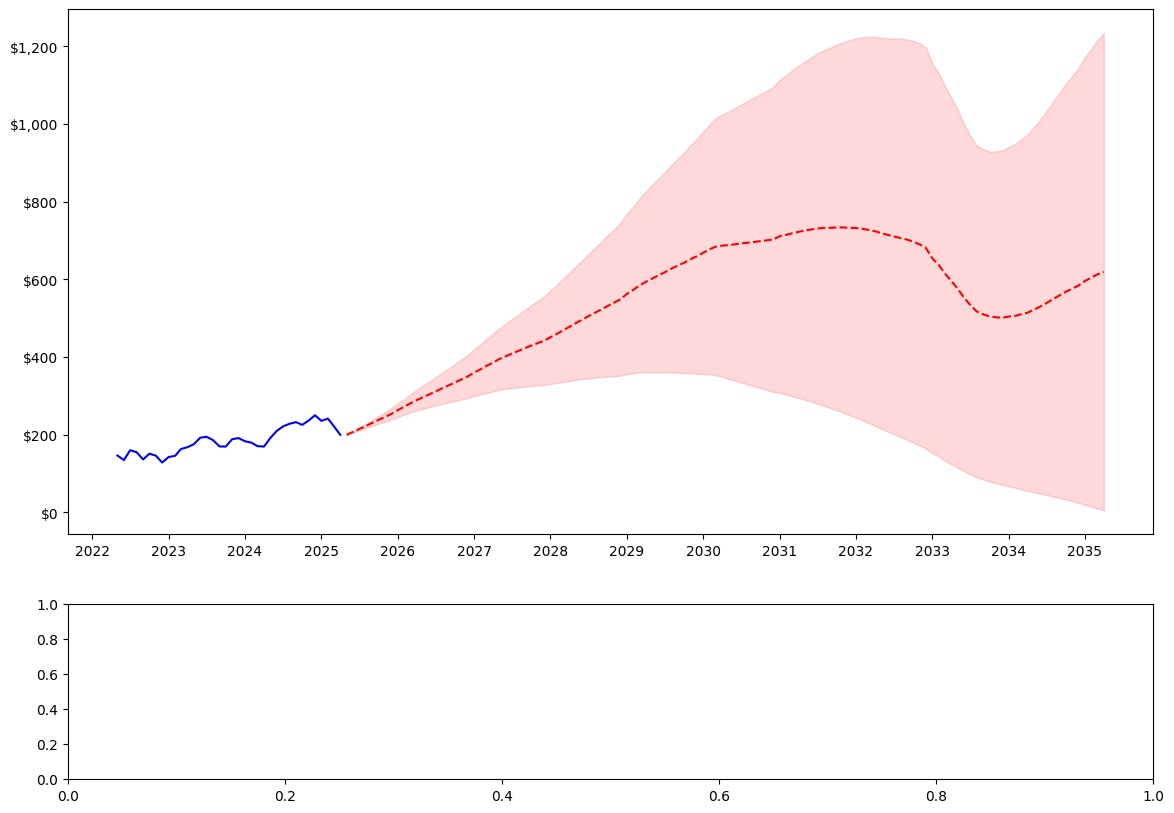

In [ ]:
def predict_other_stock_ten_years(model, sp500_scaler, ticker='AAPL', seq_length=24, prediction_years=10):
    import numpy as np
    import pandas as pd
    import yfinance as yf
    from datetime import datetime, timedelta

    prediction_months = prediction_years * 12

    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*3)

    stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
    stock_prices = stock_data['Close'].values
    stock_scaled = sp500_scaler.transform(stock_prices.reshape(-1, 1))
    last_sequence = stock_scaled[-seq_length:]
    current_month = datetime.now().month

    predictions = []
    current_sequence = last_sequence.copy()

    for i in range(prediction_months):
        pred_month = np.array([[(current_month + i) % 12 + 1]]) / 12.0
        pred = model.predict([current_sequence.reshape(1, seq_length, 1), pred_month], verbose=0)
        predictions.append(pred[0][0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred

    predictions = sp500_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    last_date = stock_data.index[-1]
    prediction_dates = [last_date + pd.DateOffset(months=i+1) for i in range(prediction_months)]

    pred_df = pd.DataFrame({
        'Date': prediction_dates,
        f'Predicted_{ticker}': predictions.flatten()
    })

    last_actual_price = stock_prices[-1]
    first_predicted_price = predictions[0][0]

    if first_predicted_price != 0:
        adjustment_factor = last_actual_price / first_predicted_price
        pred_df[f'Adjusted_{ticker}'] = pred_df[f'Predicted_{ticker}'] * adjustment_factor
    else:
        pred_df[f'Adjusted_{ticker}'] = pred_df[f'Predicted_{ticker}']

    # Add yearly aggregations
    pred_df['Year'] = pred_df['Date'].dt.year
    yearly_avg = pred_df.groupby('Year')[f'Adjusted_{ticker}'].agg(['mean', 'min', 'max'])
    yearly_avg.columns = [f'Yearly_Avg_{ticker}', f'Yearly_Min_{ticker}', f'Yearly_Max_{ticker}']

    # Add compound annual growth rate (CAGR) calculation
    years = prediction_years
    initial_price = last_actual_price
    final_price = pred_df[f'Adjusted_{ticker}'].iloc[-1]
    cagr = (final_price / initial_price) ** (1 / years) - 1

    results = {
        'predictions': pred_df,
        'historical_data': stock_data,
        'yearly_summary': yearly_avg,
        'cagr': cagr * 100  # Convert to percentage
    }

    return results

def visualize_long_term_predictions(prediction_results, ticker='AAPL'):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter

    pred_df = prediction_results['predictions']
    historical_data = prediction_results['historical_data']
    yearly_summary = prediction_results['yearly_summary']
    cagr = prediction_results['cagr']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Main price chart (top)
    ax1.plot(historical_data.index, historical_data['Close'], label=f'Historical {ticker}', color='blue')
    ax1.plot(pred_df['Date'], pred_df[f'Adjusted_{ticker}'], label=f'Predicted {ticker}', color='red', linestyle='--')

    # Uncertainty bounds
    upper_bound = pred_df[f'Adjusted_{ticker}'] * (1 + 0.1 * (pred_df.index / 12))  # Increasing uncertainty over time
    lower_bound = pred_df[f'Adjusted_{ticker}'] * (1 - 0.1 * (pred_df.index / 12))
    ax1.fill_between(pred_df['Date'], lower_bound, upper_bound, color='red', alpha=0.15)

    # Format the x-axis to show years
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())

    # Format y-axis to show dollar amounts
    def dollar_format(x, pos):
        return f'${x:,.0f}'

    ax1.yaxis.set_major_formatter(FuncFormatter(dollar_format))

    ax1.set_title(f'{ticker} 10-Year Price Prediction (CAGR: {cagr:.2f}%)', fontsize=16)
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=historical_data.index[-1], color='green', linestyle='-', alpha=0.7, label='Current Date')

    # Yearly summary chart (bottom)
    years = yearly_summary.index
    ax2.bar(years, yearly_summary[f'Yearly_Avg_{ticker}'], alpha=0.7, color='blue')
    ax2.errorbar(years, yearly_summary[f'Yearly_Avg_{ticker}'],
                [yearly_summary[f'Yearly_Avg_{ticker}'] - yearly_summary[f'Yearly_Min_{ticker}'],
                 yearly_summary[f'Yearly_Max_{ticker}'] - yearly_summary[f'Yearly_Avg_{ticker}']],
                fmt='o', color='black', alpha=0.7)

    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Yearly Avg Price ($)', fontsize=12)
    ax2.yaxis.set_major_formatter(FuncFormatter(dollar_format))
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return plt


aapl_long_term = predict_other_stock_ten_years(
    model=ensemble_models[0],
    sp500_scaler=scaler,
    ticker='AAPL'
)

# Visualize long-term predictions
plt_long = visualize_long_term_predictions(aapl_long_term, ticker='AAPL')
plt_long.savefig('aapl_10_year_forecast.png', dpi=300)
plt_long.show()

# Print summary statistics
print(f"AAPL 10-Year Forecast Summary:")
print(f"CAGR: {aapl_long_term['cagr']:.2f}%")
print("\nYearly Price Projections:")
print(aapl_long_term['yearly_summary'])
